[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DavideDaz/TokyoDataScience/blob/master/Machine%20Learning%20Projects/GTSRB/gtsrb_resnet50Wide_WAdam_10%25val_Norm.ipynb)

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import numpy as np 
import pandas as pd

import os
import matplotlib.pyplot as plt

import seaborn as sn
import shutil 

sn.set()

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
ls "/content/drive/My Drive/Data Colab"

data.zip  gtsrb-german-traffic-sign.zip  gtsrb_mod.zip


In [0]:
from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/Data Colab/gtsrb_mod.zip', 'r') as zipObj:
   zipObj.extractall('data')

In [0]:
names_dic = {
    '0':'20limit','1':'30limit','2':'50limit','3':'60limit','4':'70limit','5':'80limit','6':'80finish','7':'100limit','8':'120limit','9':'nooverlap','10':'notruckoverlap',
     '11':'dangercross','12':'precedence','13':'giveprecedence','14':'stop','15':'novehicles','16':'notruck','17':'noaccess','18':'genericdanger','19':'suddenturnleft',
    '20':'suddenturnright','21':'tornante','22':'bumpsyellow','23':'slippery','24':'lanereduction','25':'workyellow', '26':'trafficlight','27':'zebras', '28':'children',
    '29':'bicycle', '30':'snow', '31':'wildanimals', '32':'endlimit','33':'rightturn','34':'leftturn','35':'straight','36':'straightright','37':'straighleft',
    '38':'stayright','39':'stayleft','40':'roundabout','41':'endoverlap','42':'endtruckoverlap'
            }

In [0]:
os.rename(r'/content/data/gtsrb_mod/train', r'/content/data/gtsrb_mod/Train')
os.rename(r'/content/data/gtsrb_mod/test', r'/content/data/gtsrb_mod/Test')

## Set Normalization

In [0]:
train_dataset=[]
labels=[]

height = 200
width = 200
channels = 3
classes = 43
n_inputs = height * width*channels

In [0]:
transform_tensor = transforms.Compose(
    [transforms.Resize((height,width)),
     transforms.ToTensor()])

def loader_normalization(data_path): 
    dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform =transform_tensor
    )

    normalization_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=32,
        num_workers=1,
        shuffle=False
    )
    return normalization_loader

In [0]:
loader = loader_normalization('/content/data/gtsrb_mod/Train')


mean = 0.
std = 0.
for images, _ in loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(loader.dataset)
std /= len(loader.dataset)

In [0]:
print(mean , std)

tensor([0.3403, 0.3122, 0.3214]) tensor([0.1635, 0.1635, 0.1732])


# Organize the folders of the Test set

In [0]:
test_data = pd.read_csv(r'data/gtsrb_mod/Test.csv')

In [0]:
test_data.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [0]:
for i in range(43):
    os.mkdir(r'/content/data/gtsrb_mod/Test/'+str(i)) 
for j in range(0,len(test_data['Path'])):
  source = r'data/gtsrb_mod/'+ test_data['Path'][j]
  destination = r'data/gtsrb_mod/Test/'+ str(test_data['ClassId'][j])+'/'
  shutil.move(source, destination)

# Create the Validation Set

In [0]:
list_file = os.listdir('data/gtsrb_mod/Train/0') 
number_files = len(list_file)

In [0]:
number_validation_files = int(number_files*0.1)
print(number_validation_files)

21


In [0]:
os.mkdir(r'/content/data/gtsrb_mod/Validation')
for i in range(43):
  os.mkdir(r'/content/data/gtsrb_mod/Validation/'+str(i))    

In [0]:
for i in range(43):
  list_file = os.listdir('data/gtsrb_mod/Train/'+str(i))
  indexes = np.random.choice(range(len(list_file)), number_validation_files, replace=False)
  for ind in indexes:
      source = '/content/data/gtsrb_mod/Train/'+ str(i) + '/'+list_file[ind]
      destination = r'/content/data/gtsrb_mod/Validation/'+ str(i) + '/'  
      shutil.move(source, destination)

In [0]:
for i in range(10):
  os.rename(r'/content/data/gtsrb_mod/Test/'+str(i),(r'/content/data/gtsrb_mod/Test/'+'0'+str(i)))
  os.rename(r'/content/data/gtsrb_mod/Train/'+str(i),(r'/content/data/gtsrb_mod/Train/'+'0'+str(i)))
  os.rename(r'/content/data/gtsrb_mod/Validation/'+str(i),(r'/content/data/gtsrb_mod/Validation/'+'0'+str(i))) 

# Load the Training Dataset

In [0]:
normalize = transforms.Normalize(mean=[0.3403, 0.3122, 0.3214],
                                 std=[0.1635, 0.1635, 0.1732])


transform = transforms.Compose(
    [transforms.Resize((height,width)),
     transforms.ToTensor(),
     normalize])
     

In [0]:
def loader_dataset(data_path): 
    dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )
    print(dataset.class_to_idx)
    train_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=32,
        num_workers=0,
        shuffle=True
    )
    return train_loader

In [0]:
def loader_validation(data_path): 
    dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )
    print(dataset.class_to_idx)

    train_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=32,
        num_workers=0,
        shuffle=True
    )
    return train_loader

In [0]:
def loader_test(data_path): 
    dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )
    print(dataset.class_to_idx)
    test_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=32,
        num_workers=0,
        shuffle=True
    )
    return test_loader

In [0]:
training_loader = loader_dataset(r'/content/data/gtsrb_mod/Train')

{'00': 0, '01': 1, '02': 2, '03': 3, '04': 4, '05': 5, '06': 6, '07': 7, '08': 8, '09': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42}


# Load the Validation Dataset

In [0]:
validation_loader = loader_validation(r'/content/data/gtsrb_mod/Validation')

{'00': 0, '01': 1, '02': 2, '03': 3, '04': 4, '05': 5, '06': 6, '07': 7, '08': 8, '09': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42}


# Visualize a minibatch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


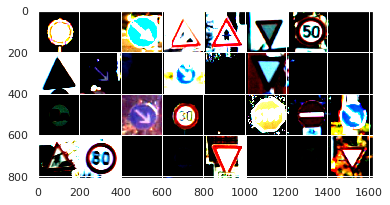

tensor([ 4,  8, 38, 25, 11, 13,  2, 15, 20, 38,  7, 38,  3, 13, 35, 10, 10, 10,
        38,  1, 38, 14, 17, 38, 25,  5, 17,  7, 13, 35,  6, 13])


In [0]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(training_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(labels)

# Define the Network

In [0]:


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

net = wide_resnet50_2()

# Use Cuda

In [0]:
torch.cuda

<module 'torch.cuda' from '/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py'>

In [0]:
use_cuda = True

In [0]:
if use_cuda and torch.cuda.is_available():
    net = net.cuda()

In [0]:
torch.cuda.empty_cache()

In [0]:
!nvidia-smi

Sun Feb  2 08:27:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W /  70W |   1097MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [0]:
from torchsummary import summary
summary(net, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]           8,192
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,456
       BatchNorm2d-9          [-1, 128, 32, 32]             256
             ReLU-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          32,768
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.000001)

dic = {'train':training_loader, 'validation':validation_loader}

# Train the Model

In [0]:
train_acc = []
train_loss = []
val_acc = []
val_loss = []

In [0]:
for epoch in range(50):  # loop over the dataset multiple times
    
    for phase in ['train', 'validation']:

      if phase == 'train':
          net.train(True)  # Set model to training mode
      else:
          net.train(False)  # Set model to evaluate mode

      running_loss = 0.0
      total_train = 0
      correct_train = 0
      
      
      for i, data in enumerate(dic[phase], 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.cuda()
          labels =labels.cuda()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          
          if phase == 'train':
              loss.backward()
              optimizer.step()

                # accuracy
              _, predicted = torch.max(outputs.data, 1)
              total_train += labels.size(0)
              correct_train += predicted.eq(labels.data).sum().item()
              train_accuracy = 100 * correct_train / total_train

              # print statistics
              running_loss += loss.item()
              if i % 32 == 31:    # print every 32 mini-batches
                  print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 32),
                        "Training Accuracy: %.4f %%" % (train_accuracy))
                  running_loss = 0.0
              if i / 1184 == 1:    
                  train_acc.append(train_accuracy)
                  train_loss.append(running_loss)
                  
          torch.cuda.empty_cache()
              
          if phase == 'validation':

            with torch.no_grad():
              
                  # accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += predicted.eq(labels.data).sum().item()
                validation_accuracy = 100 * correct_train / total_train

                # print statistics
                running_loss += loss.item()
                if i % 25 == 24:    # print every 32 mini-batches
                  print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss/32),
                            "Validation Accuracy: %.4f %%" % (validation_accuracy))
                  running_loss = 0.0
                if i / 25 == 1:
                  val_acc.append(validation_accuracy)
                  val_loss.append(running_loss)

                torch.cuda.empty_cache()
    PATH = './gtsrb_model_es'+str(epoch)+'.pth'
    torch.save(net.state_dict(), PATH)
print('Finished Training')

[1,    32] loss: 0.000 Training Accuracy: 100.0000 %
[1,    64] loss: 0.000 Training Accuracy: 100.0000 %
[1,    96] loss: 0.000 Training Accuracy: 100.0000 %
[1,   128] loss: 0.000 Training Accuracy: 100.0000 %
[1,   160] loss: 0.000 Training Accuracy: 100.0000 %
[1,   192] loss: 0.000 Training Accuracy: 100.0000 %
[1,   224] loss: 0.000 Training Accuracy: 100.0000 %
[1,   256] loss: 0.000 Training Accuracy: 100.0000 %
[1,   288] loss: 0.000 Training Accuracy: 100.0000 %
[1,   320] loss: 0.000 Training Accuracy: 100.0000 %
[1,   352] loss: 0.000 Training Accuracy: 100.0000 %
[1,   384] loss: 0.000 Training Accuracy: 100.0000 %
[1,   416] loss: 0.000 Training Accuracy: 100.0000 %
[1,   448] loss: 0.000 Training Accuracy: 100.0000 %
[1,   480] loss: 0.000 Training Accuracy: 100.0000 %
[1,   512] loss: 0.000 Training Accuracy: 100.0000 %
[1,   544] loss: 0.000 Training Accuracy: 100.0000 %
[1,   576] loss: 0.000 Training Accuracy: 100.0000 %
[1,   608] loss: 0.000 Training Accuracy: 100.

KeyboardInterrupt: ignored

In [0]:
epochs = range(1,len(val_acc)+1)

In [0]:
len(val_acc)

20

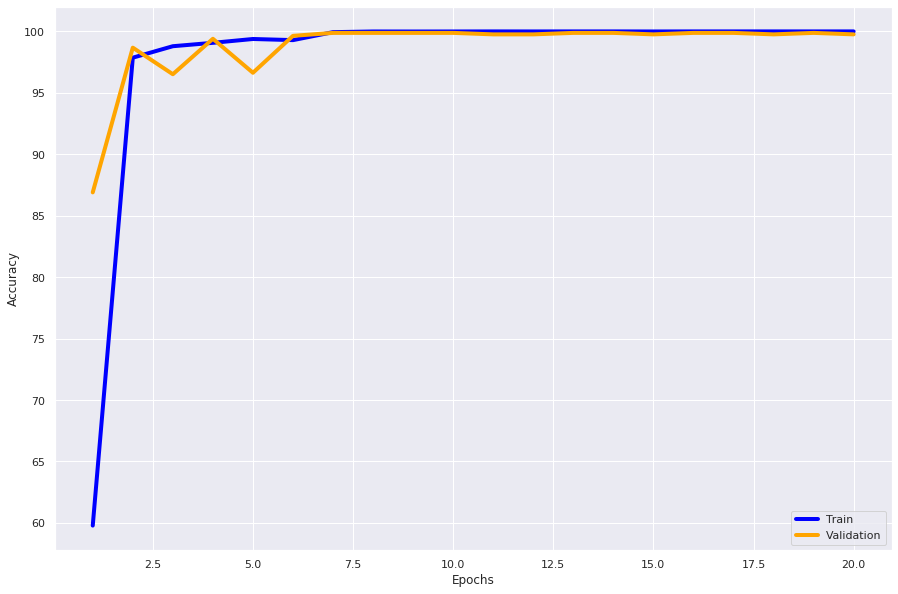

In [0]:
plt.figure(figsize=(15,10))
plt.plot(epochs,train_acc, color='blue',linewidth=4)
plt.plot(epochs,val_acc, color='orange',linewidth=4)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(( 'Train','Validation'),
           loc='lower right')

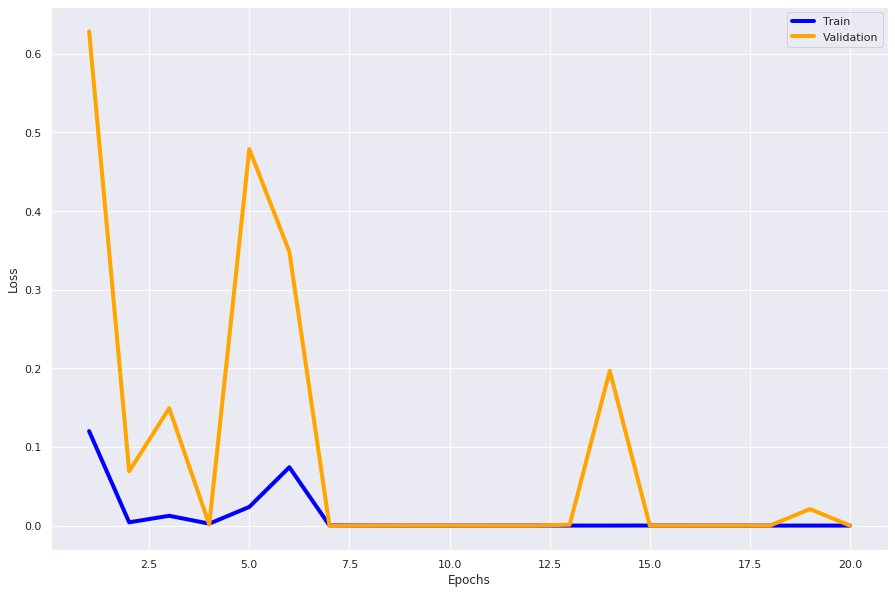

In [0]:
plt.figure(figsize=(15,10))
plt.plot(epochs,train_loss, color='blue',linewidth=4)
plt.plot(epochs,val_loss, color='orange',linewidth=4)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(( 'Train','Validation'),
           loc='upper right')

# Load the Test Data

In [0]:
test_loader = loader_test(r'/content/data/gtsrb_mod/Test')

{'00': 0, '01': 1, '02': 2, '03': 3, '04': 4, '05': 5, '06': 6, '07': 7, '08': 8, '09': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42}


# Predict the data set and evaluate the accuray

In [0]:
for i in range(15,34):
  PATH = 'gtsrb_model_es'+str(i)+'.pth'
  net = wide_resnet50_2().cuda()
  net.load_state_dict(torch.load(PATH))
  correct = 0
  total = 0
  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          images = images.cuda()
          labels =labels.cuda()
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  print("Model "+ str(i)+':')
  print('Accuracy of the network on the 10000 test images: %.4f %%' % (
      100 * correct / total))

Model 15:
Accuracy of the network on the 10000 test images: 86.6904 %
Model 16:
Accuracy of the network on the 10000 test images: 94.5527 %
Model 17:
Accuracy of the network on the 10000 test images: 93.6263 %
Model 18:
Accuracy of the network on the 10000 test images: 96.8171 %
Model 19:
Accuracy of the network on the 10000 test images: 95.2890 %
Model 20:
Accuracy of the network on the 10000 test images: 97.3872 %
Model 21:
Accuracy of the network on the 10000 test images: 98.1789 %
Model 22:
Accuracy of the network on the 10000 test images: 98.3135 %
Model 23:
Accuracy of the network on the 10000 test images: 98.3927 %
Model 24:
Accuracy of the network on the 10000 test images: 98.4877 %
Model 25:
Accuracy of the network on the 10000 test images: 98.3690 %
Model 26:
Accuracy of the network on the 10000 test images: 98.4402 %
Model 27:
Accuracy of the network on the 10000 test images: 98.6461 %
Model 28:
Accuracy of the network on the 10000 test images: 98.3927 %
Model 29:
Accuracy o

In [0]:
for i in range(1):
  PATH = 'gtsrb_model_es'+str(i)+'.pth'
  net = wide_resnet50_2().cuda()
  net.load_state_dict(torch.load(PATH))
  correct = 0
  total = 0
  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          images = images.cuda()
          labels =labels.cuda()
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  print("Model "+ str(i)+':')
  print('Accuracy of the network on the 10000 test images: %.4f %%' % (
      100 * correct / total))

Model 0:
Accuracy of the network on the 10000 test images: 98.6857 %
